In [38]:
%load_ext autoreload
%autoreload 2

from typing import Any, Dict, Tuple

import pandas as pd
import numpy as np

from models import models, scalers
from read_data import read_datasets
from data_cleaning import prep_dataframe, DataCleaner
from training import split_x_y, calc_stats, select_past, train_test_year

from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Datasets

Copies of the dataset, each with a different scaler applies, are generated and stored for usage in training.

In [35]:
dep_var = "Log(Rmax)"
# dep_var = "Log(Efficiency)"
use_crossval = True

all_data = read_datasets()
num_sets = len(all_data)
all_data = prep_dataframe(all_data, dep_var)

num_sets


Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.20GHz' @ Earth Simulator, 2009
Unknown processor: 'Xeon EM64T', full name: 'Xeon EM64T  3.60GHz' @ Thunderbird, 2006


20

In [92]:
cleaners = {}


def train_model(model, past_sets: int, train: Tuple[pd.DataFrame, pd.Series], test: Tuple[pd.DataFrame, pd.Series]) -> Dict[str, Any]:
    # 0 is X (features), 1 is y (dependent variable)
    model.fit(train[0], train[1])

    pred_y = model.predict(test[0])
    scaled = calc_stats(test[1], pred_y, print_res=False)

    cleaner = cleaners[past_sets]

    # Make full df with results so we can unscale them
    scaled_res = test[0].copy()
    scaled_res[dep_var] = test[1]
    exp_unscaled_test: pd.DataFrame = cleaner.inverse_transform(scaled_res)
    exp_unscaled_y = np.e ** exp_unscaled_test[dep_var]

    scaled_res[dep_var] = pred_y
    pred_unscaled_test: pd.DataFrame = cleaner.inverse_transform(scaled_res)
    pred_unscaled_y = np.e ** pred_unscaled_test[dep_var]

    unscaled = calc_stats(exp_unscaled_y, pred_unscaled_y, print_res=False)

    # Take the unscaled data and prefix it so it can be combined with the scaled data
    return {f"u{key}": val for key, val in unscaled.items()} | scaled


In [93]:
# Hard code in scaler for now
scaler = scalers["Robust"]

results = pd.DataFrame(columns=["name", "past_sets", "scaler",
                       "r2", "mae", "mape", "mse", "ur2", "umae", "umape", "umse"])

num_to_sweep = (num_sets + 1) - 2
sets_pbar = tqdm(total=num_to_sweep)
total_pbar = tqdm(total=num_to_sweep * len(models))

for past_sets in range(2, num_sets+1):
    cleaner = DataCleaner(scaler, dep_var)
    cleaners[past_sets] = cleaner

    data = select_past(all_data, past_sets)
    data = cleaner.fit_transform(data)
    train, test = train_test_year(data)

    train, test = split_x_y([train, test], dep_var)

    for name, model in models.items():
        res = train_model(model, past_sets, train, test)
        res["name"] = name
        res["past_sets"] = past_sets

        results = results.append(res, ignore_index=True)

        total_pbar.update(1)

    sets_pbar.update(1)

sets_pbar.close()
total_pbar.close()

results


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

Filtered duplicates to go from 1000 rows to 436


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 1500 rows to 491


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 2000 rows to 541


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 2500 rows to 607


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 3000 rows to 694


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 3500 rows to 834


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 4000 rows to 956
Filtered duplicates to go from 4500 rows to 1094


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 5000 rows to 1211


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 5500 rows to 1321
Filtered duplicates to go from 6000 rows to 1483


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Filtered duplicates to go from 6500 rows to 1622
Filtered duplicates to go from 7000 rows to 1697
Filtered duplicates to go from 7500 rows to 1782
Filtered duplicates to go from 8000 rows to 1888
Filtered duplicates to go from 8500 rows to 2023
Filtered duplicates to go from 9000 rows to 2164
Filtered duplicates to go from 9500 rows to 2314
Filtered duplicates to go from 10000 rows to 2476


,name,past_sets,scaler,r2,mae,mape,mse,ur2,umae,umape,umse
0,lr_1,2,NaN,-0.184015,0.624756,0.069829,0.736323,-0.094304,4361.001759,0.454138,9.520006e+07
1,knn_1,2,NaN,0.512455,0.390733,0.043845,0.303198,0.493166,3035.204232,0.295030,4.409254e+07
2,knn_2,2,NaN,0.451113,0.416426,0.046714,0.341345,0.425118,3178.653496,0.309885,5.001242e+07
3,knn_3,2,NaN,0.436588,0.411434,0.046082,0.350378,0.455991,3034.627038,0.296875,4.732665e+07
4,knn_4,2,NaN,0.419870,0.444861,0.049814,0.360775,0.382890,3433.022156,0.332986,5.368609e+07
...,...,...,...,...,...,...,...,...,...,...,...
451,mlp_1,20,NaN,-1.577180,0.854281,0.099283,1.602712,-0.262894,4756.375505,0.600486,1.098668e+08
452,dnn1_1,20,NaN,0.711075,0.311734,0.035783,0.179678,0.726038,2319.710610,0.245684,2.383363e+07
453,dnn2_1,20,NaN,-1.624283,0.799851,0.090792,1.632005,-0.094236,4119.403594,0.435965,9.519420e+07
454,xgb_1,20,NaN,0.709578,0.305902,0.034647,0.180609,0.767097,2323.025499,0.245141,2.026163e+07


In [1]:
results.sort_values("ur2", axis=0, ascending=False)


NameError: name 'results' is not defined

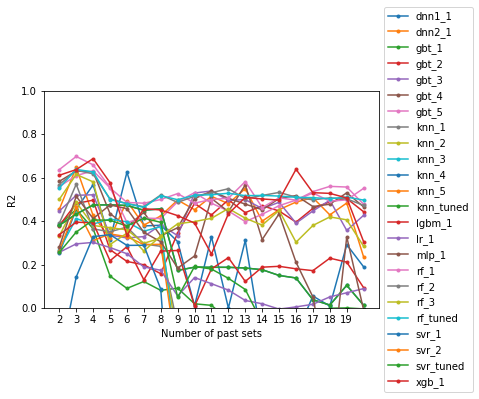

In [19]:
import matplotlib.pyplot as plt

for p in results.groupby(["name"]):
    name, res = p
    data = results[results["name"] == name]
    plt.plot(res["past_sets"], res["r2"], linestyle="-", marker=".", label=name)
    plt.xticks(range(2, num_sets))
    plt.xlabel("Number of past sets")
    plt.ylabel("R2")

# plt.wi
plt.ylim(0, 1)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [40]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', labelsize=MEDIUM_SIZE + 5)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, dpi=300)  # fontsize of the figure title


In [46]:
subplot_dict = {"lr":  0, "knn": 1, "svr": 2, "rf":  3,
                "gbt": 4, "mlp": 5, "dnn": 6, "xgb": 7, "lgbm": 8}
fig, axes = plt.subplots(len(subplot_dict), 2, figsize=(
    20, 35))

# Stored so we can use them later in error graph
key_translations = {}
left_stat = "r2"

for name in models.keys():
    # Find the matching plot
    for name_part, val in subplot_dict.items():
        if name_part in name:
            type_plot = axes[val][0]
            key_translations[name] = name_part
            break
    else:
        raise ValueError(f"Invalid model name '{name}'")

    # Plot the data
    res = results[results["name"] == name]
    type_plot.plot(res["past_sets"], res[left_stat],
                   linestyle="-", marker=".", label=name)

# Error graphs
results_sorted = results.sort_values(by=left_stat, ascending=False)
subplot_errors = {}
right_stat = "mae"
for name in results_sorted["name"].unique():  # type: ignore
    name_part = key_translations[name]
    if name_part not in subplot_errors:
        subplot_errors[name_part] = name
        best_plot = axes[subplot_dict[name_part]][1]

        this_type = results[results["name"] == name]
        best_plot.bar(this_type["past_sets"], this_type[right_stat], label=name)
        best_plot.plot(this_type["past_sets"], this_type[right_stat],
                       "r", linestyle="-", marker=".")

        # best_plot.set_ylim(0, 1.25)
        best_plot.set_ylabel(right_stat.upper())
        best_plot.set_xticks(range(2, num_sets + 1))
        best_plot.legend()


for name_part, val in subplot_dict.items():
    type_plot = axes[val][0]
    type_plot.set_title(name_part)
    type_plot.set_ylabel(left_stat.upper())
    type_plot.set_xticks(range(2, num_sets + 1))
    type_plot.legend()

axes[-1][-2].set_xlabel("TOP500 lists used")
axes[-1][-1].set_xlabel("TOP500 lists used")

fig.suptitle("Model Performance and Error for Log(Rmax) with ToP", y=0.99)

fig.tight_layout()


In [114]:
# Take only the maximum scaler config for each model
max_indices = results.groupby(["name"])["r2"].idxmax()
maximums = results.loc[max_indices]
print(maximums["past_sets"].mean())
maximums.sort_values(by="r2", ascending=False)

6.708333333333333


,name,past_sets,scaler,r2,mae,mape,mse,ur2,umae,umape,umse
260,dnn1_1,12,NaN,0.819098,0.229118,0.026246,0.112500,0.906387,1623.236708,0.190689,8.143920e+06
142,xgb_1,7,NaN,0.808266,0.252220,0.028353,0.119236,0.787951,2149.724290,0.209590,1.844739e+07
64,gbt_3,4,NaN,0.670405,0.339418,0.038143,0.204970,0.676812,2689.082528,0.265502,2.811604e+07
137,gbt_4,7,NaN,0.652853,0.349139,0.039372,0.215886,0.689478,2674.357426,0.275156,2.701421e+07
39,gbt_2,3,NaN,0.646250,0.342815,0.038446,0.219992,0.571780,2751.433855,0.262844,3.725341e+07
210,gbt_5,10,NaN,0.645989,0.356811,0.040232,0.220154,0.626034,2778.313379,0.278493,3.253356e+07
191,lgbm_1,9,NaN,0.627201,0.341489,0.038632,0.231838,0.616392,2721.351917,0.301828,3.337238e+07
34,rf_1,3,NaN,0.567425,0.369280,0.041478,0.269012,0.637586,2785.052972,0.275161,3.152860e+07
73,knn_1,5,NaN,0.558455,0.370088,0.041352,0.274591,0.494618,2989.902495,0.278445,4.396619e+07
37,rf_tuned,3,NaN,0.546417,0.373396,0.041859,0.282077,0.619161,2792.099897,0.274800,3.313149e+07


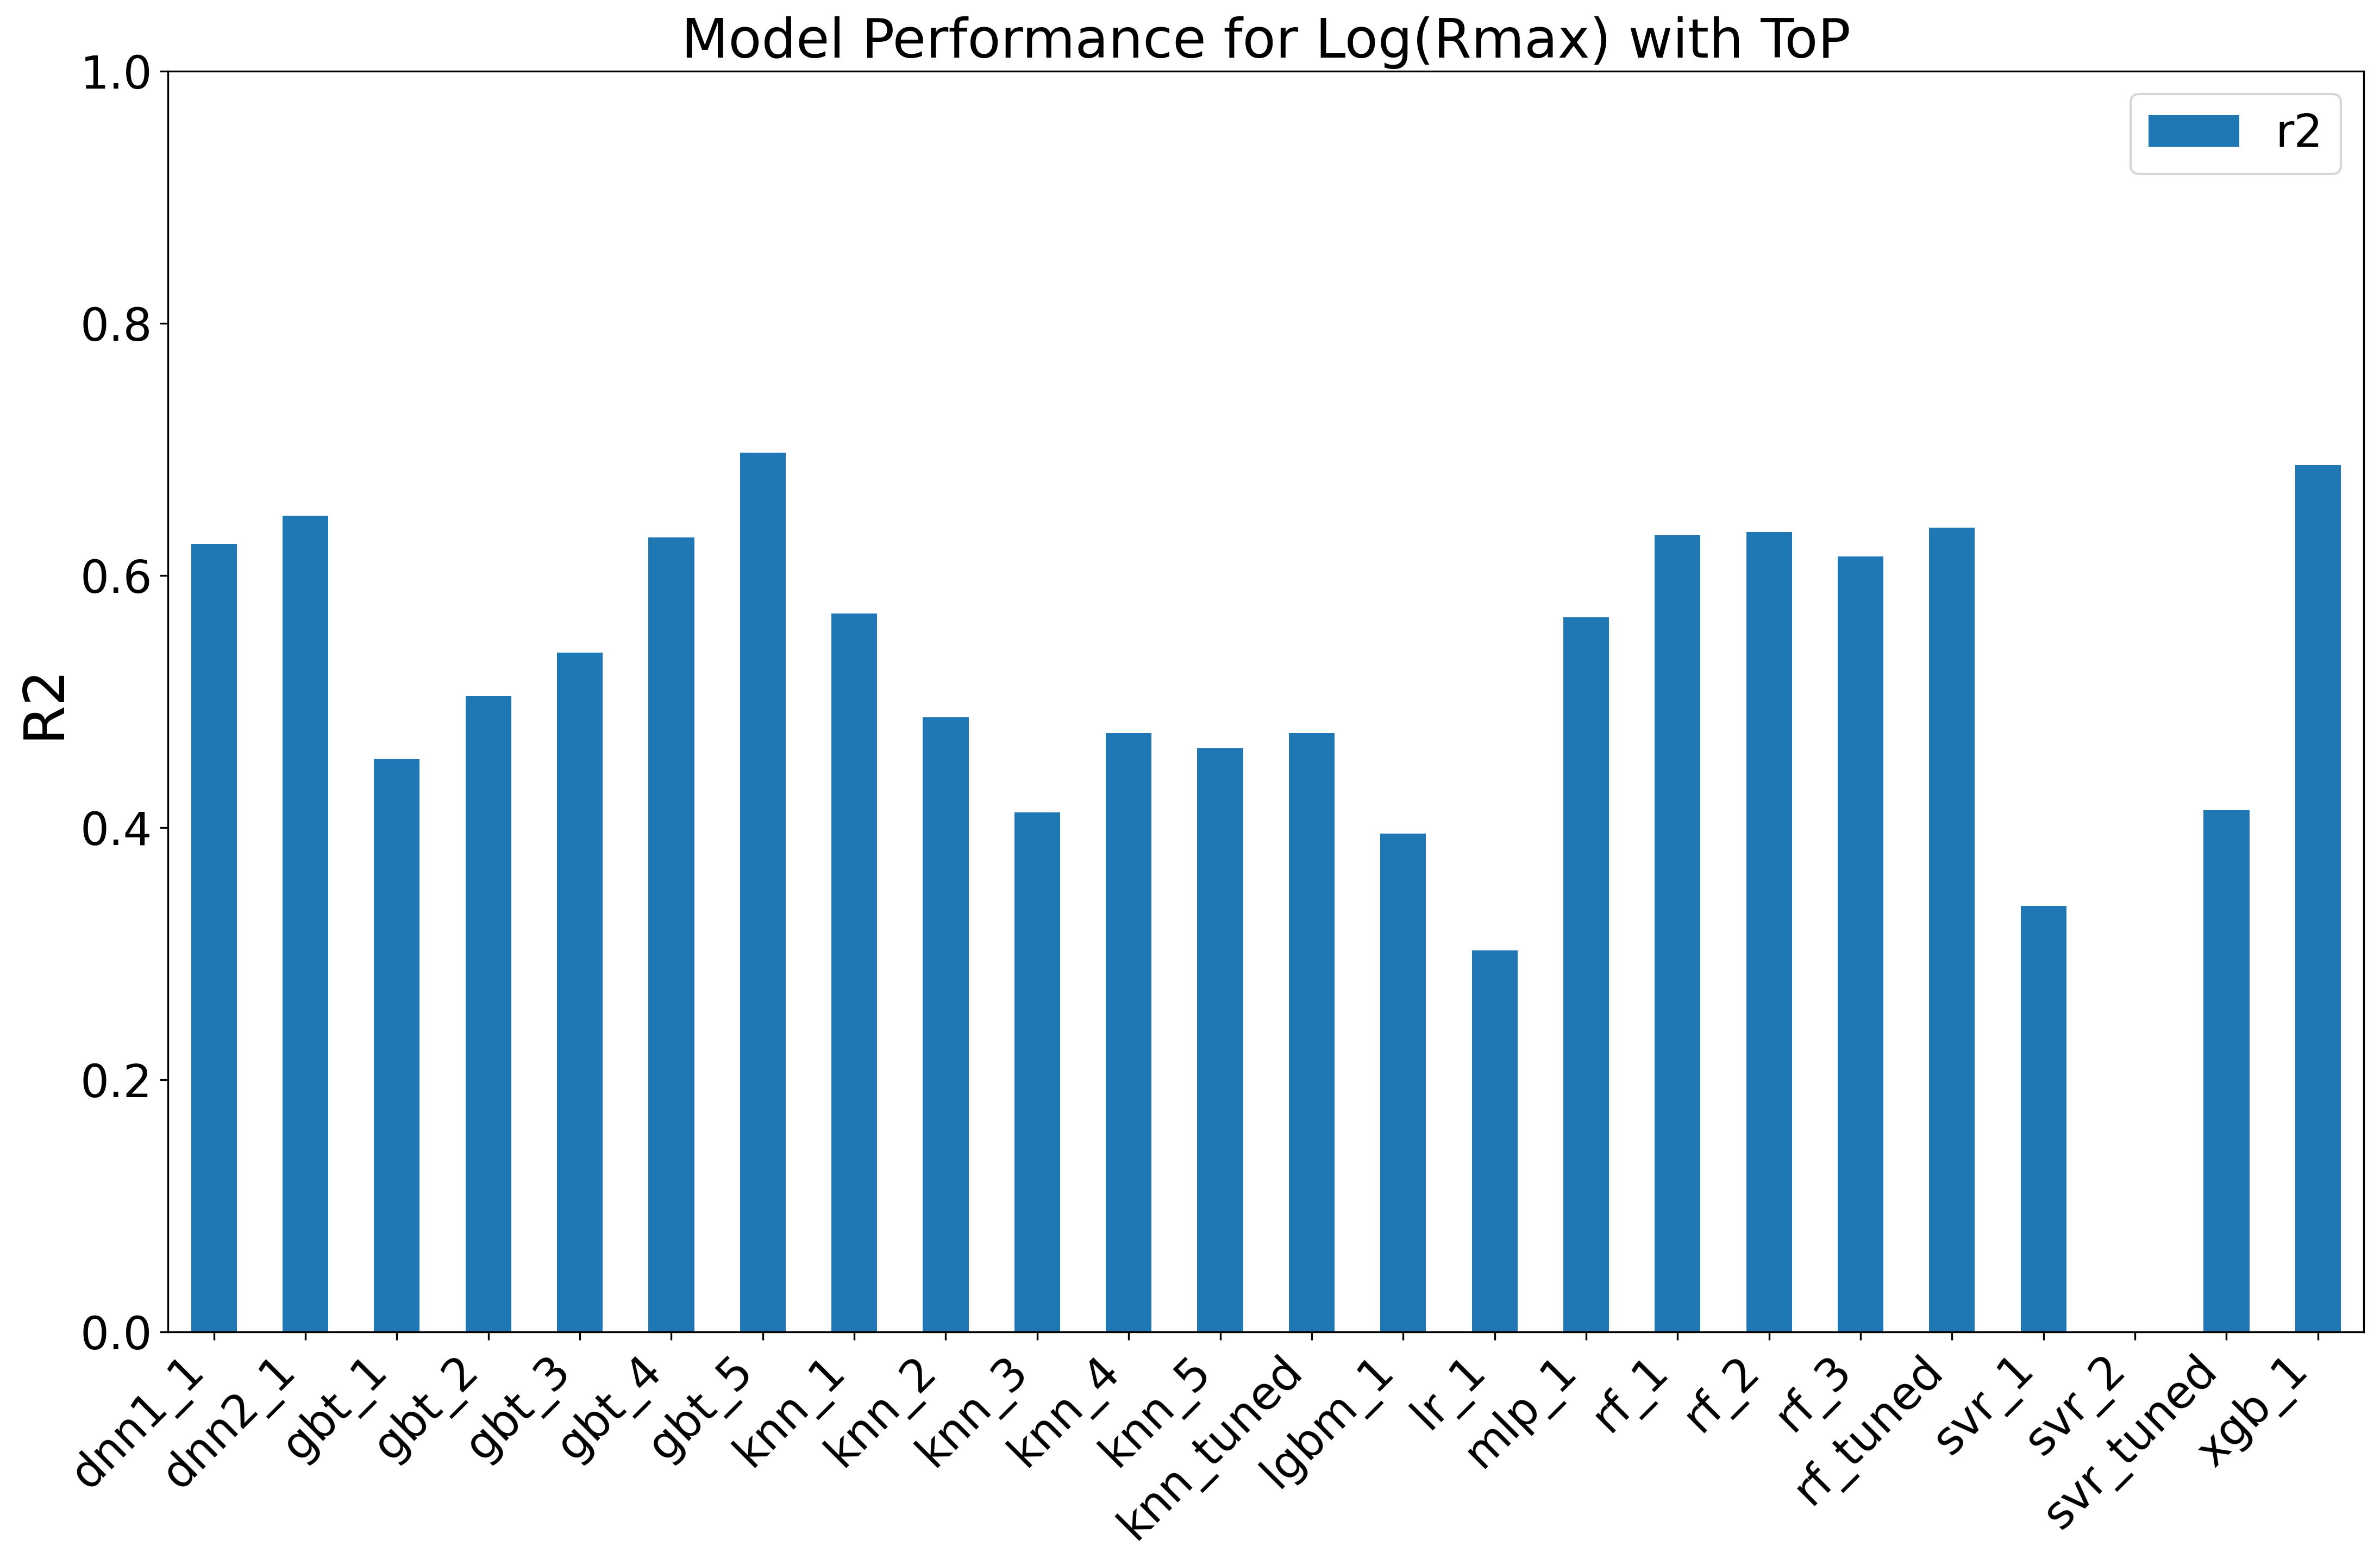

In [49]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE + 5)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=10, dpi=300)  # fontsize of the figure title

axis = maximums.plot.bar(x="name", y="r2", figsize=(
    15, 10), ylabel="R2", title="Model Performance for Log(Rmax) with ToP", xlabel="")
axis.set_xticklabels(labels=maximums["name"], rotation=45, ha="right")
axis.set_ylim(bottom=0, top=1)
axis.figure.tight_layout()


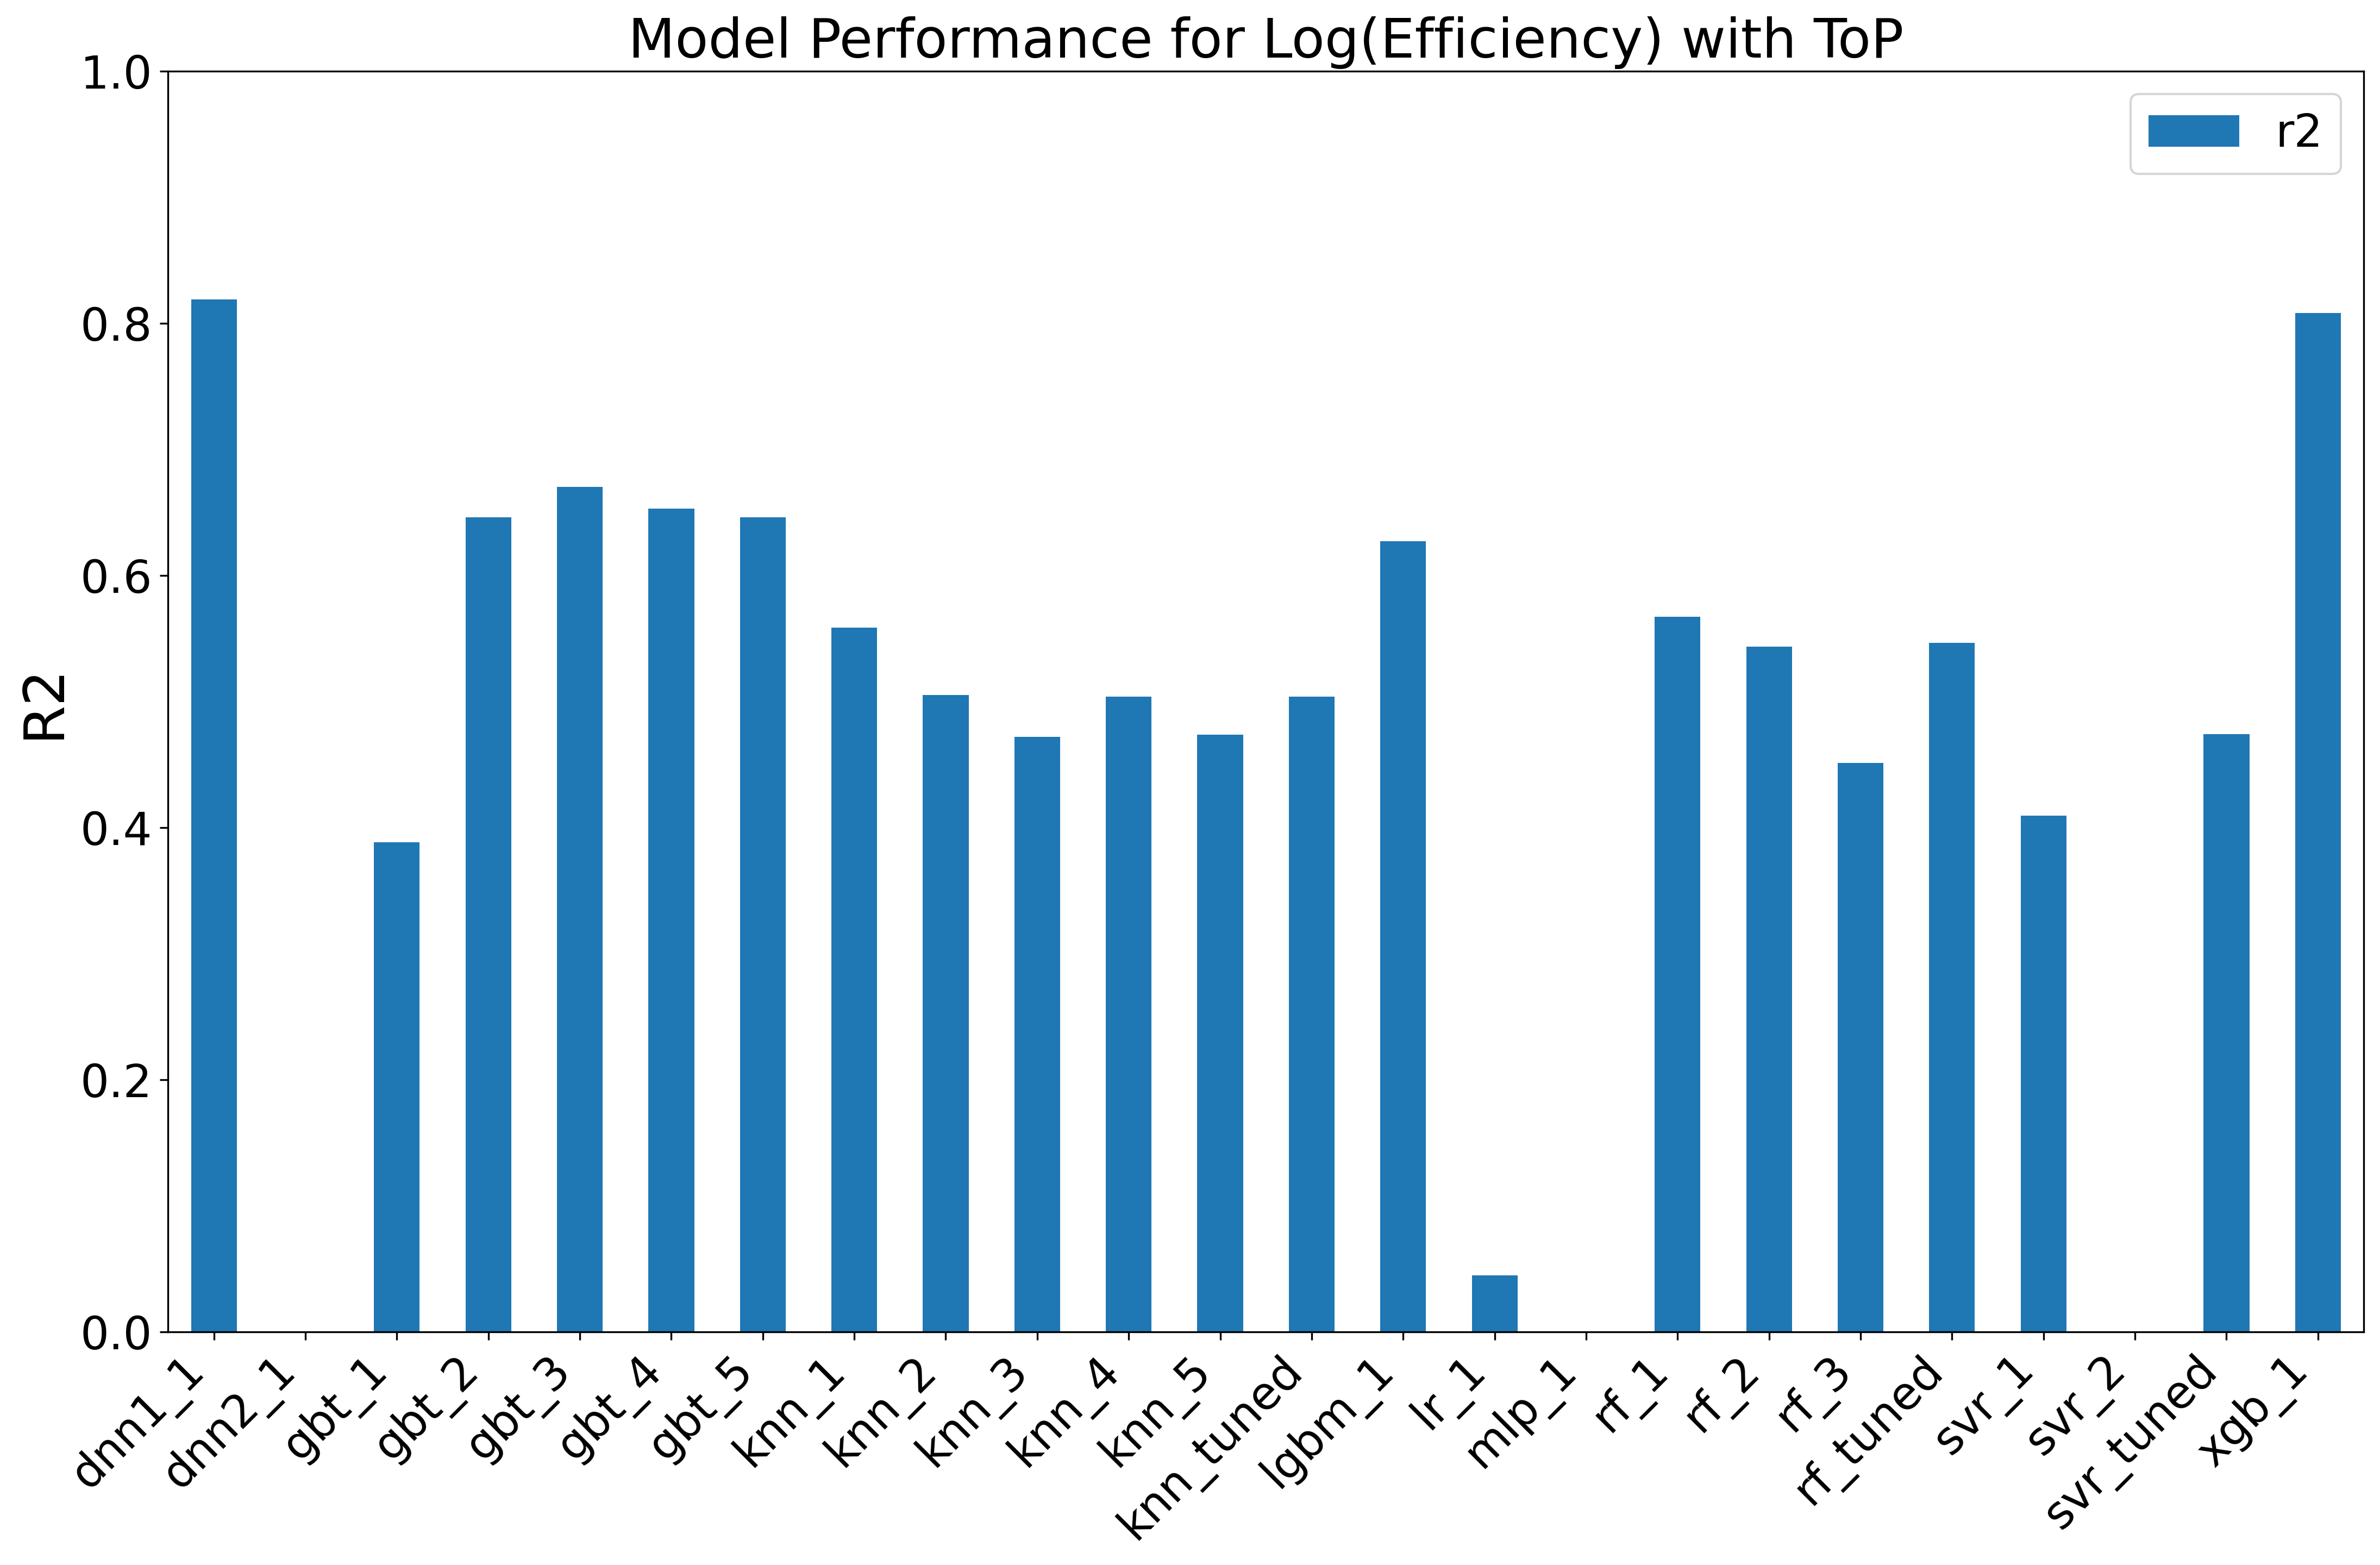

In [27]:
axis.figure

In [47]:
from datetime import datetime
import pathlib

now = datetime.now()
dt_string = now.strftime(r"%m-%d-%YT%I-%M-%S%p")
out_dir = pathlib.Path("out")

identifier = f"all_results_top_{dt_string}"
csv_path = out_dir / (identifier + ".csv")
img_path = out_dir / (identifier + ".png")
results.to_csv(csv_path)
fig.set_facecolor((1, 1, 1, 1))
fig.savefig(img_path)

identifier = f"best_results_top_{dt_string}"
csv_path = out_dir / (identifier + ".csv")
img_path = out_dir / (identifier + ".png")
maximums.to_csv(csv_path)
axis.figure.savefig(img_path)

In [58]:
import pandas as pd
import pathlib

dt_string = "04-21-2022T01-55-17AM"
# dt_string = "04-21-2022T02-15-29AM"

identifier = f"all_results_top_{dt_string}"
csv_path = out_dir / (identifier + ".csv")
results = pd.read_csv(csv_path)

identifier = f"best_results_top_{dt_string}"
out_dir = pathlib.Path("out")
csv_path = out_dir / (identifier + ".csv")
maximums = pd.read_csv(csv_path)

In [59]:
maximums.sort_values("r2", ascending=False)

,Unnamed: 0,name,past_sets,scaler,r2,mae,mape,mse,ur2,umae,umape,umse
6,42,gbt_5,3,NaN,0.697572,0.355111,0.782392,0.218691,0.603932,4.332020,0.366110,36.622731
23,70,xgb_1,4,NaN,0.687436,0.361989,0.798590,0.226020,0.550795,4.691049,0.383474,41.536109
1,45,dnn2_1,3,NaN,0.647258,0.408964,0.668072,0.255074,0.409074,5.340821,0.426148,54.640458
19,37,rf_tuned,3,NaN,0.638097,0.374191,0.761949,0.261699,0.447033,4.855813,0.365859,51.130593
17,35,rf_2,3,NaN,0.634667,0.379395,0.766153,0.264179,0.441912,4.908808,0.370148,51.604112
16,58,rf_1,4,NaN,0.631700,0.389268,0.773099,0.266325,0.433300,5.041399,0.378654,52.400398
5,41,gbt_4,3,NaN,0.630327,0.384224,0.864632,0.267317,0.526376,4.715685,0.410456,43.794045
0,116,dnn1_1,6,NaN,0.625141,0.401983,0.649967,0.271067,0.540385,4.643451,0.367945,42.498703
18,36,rf_3,3,NaN,0.614873,0.417437,0.753318,0.278492,0.422444,5.156334,0.388241,53.404194
7,25,knn_1,3,NaN,0.569820,0.405976,0.817465,0.311071,0.365061,5.239036,0.395094,58.710131
